In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import glob
%matplotlib inline
plt.rcParams['figure.figsize'] = (19.0, 17.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
#Data Preprocessing

data_dir = 'dataset/dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 

num_file = 1100 
all_files = [] 
num_data =num_file*len(classes)
Y = np.zeros(num_data)


for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file]
    Y[i*num_file:(i+1)*num_file] = i # label all classes with int [0.. len(classes)]

    
# Image dimension
im_width = 200
im_height = 200 
im_channel = 3
dim = im_width * im_height * im_channel

X = np.ndarray(shape=(num_data, im_width, im_height, im_channel), dtype=np.float64)

for idx, file in enumerate(all_files):
    X[idx] = cv2.resize(cv2.imread(file), (im_width, im_height))

X_train = np.empty(shape=(4000,im_width, im_height, im_channel), dtype=np.float64)
X_val = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)
X_test = np.empty(shape=(200,im_width, im_height, im_channel), dtype=np.float64)

y_train = np.empty(4000)
y_val = np.empty(200)
y_test = np.empty(200) 

for i, cls in enumerate(classes): 
    X_test[50*i:50*(i+1)] = X[np.where(Y == i)[0][:50]]
    X_val[50*i:50*(i+1)] = X[np.where(Y == i)[0][50:100]]
    X_train[1000*i:1000*(i+1)] = X[np.where(Y == i)[0][100:]]
    
    y_test[50*i:50*(i+1)] = i
    y_val[50*i:50*(i+1)] = i
    y_train[1000*i:1000*(i+1)] = i
    
del Y 
del X

# Extract features 
#Shuffle training index
train_idxs = np.random.permutation(X_train.shape[0])
y_train  = y_train[train_idxs].astype(int)
X_train = X_train[train_idxs]

X_train = np.reshape(X_train, (X_train.shape[0], -1)).astype('float64')
X_test = np.reshape(X_test, (X_test.shape[0], -1)).astype('float64')
X_val = np.reshape(X_val, (X_val.shape[0], -1)).astype('float64')

X_tiny = X_train[100:110].astype('float64')
y_tiny = y_train[100:110].astype(int)
num_dev = 500

X_dev = X_train[0:num_dev].astype('float64')
y_dev = y_train[0:num_dev].astype(int)
print("X_train shape", X_train.shape, "| y_train shape:", y_train.shape)
print("X_test shape", X_test.shape, "| y_test shape:", y_test.shape)
print("X_val shape", X_val.shape, "| y_val shape:", y_val.shape)
print("X_dev shape", X_dev.shape, "| y_dev shape:", y_dev.shape)
print("X_tiny shape", X_tiny.shape, "| y_tiny shape:", y_tiny.shape)

#Subtract out the mean image 
#first: compute the mean image
# mean_image = np.mean(X_train, axis=0) #axis=0. stack horizontally
mean_image = 128
#Second subtract the mean image from train and test data 
X_train -= mean_image
X_val -= mean_image 
X_test -= mean_image
X_dev -= mean_image
X_tiny -= mean_image

print('=====STACK BIAS term=====')
print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("X_val shape", X_val.shape)
print("X_dev shape", X_dev.shape)
print("X_tiny shape", X_tiny.shape)

X_train shape (4000, 120000) | y_train shape: (4000,)
X_test shape (200, 120000) | y_test shape: (200,)
X_val shape (200, 120000) | y_val shape: (200,)
X_dev shape (500, 120000) | y_dev shape: (500,)
X_tiny shape (10, 120000) | y_tiny shape: (10,)
=====STACK BIAS term=====
X_train shape (4000, 120000)
X_test shape (200, 120000)
X_val shape (200, 120000)
X_dev shape (500, 120000)
X_tiny shape (10, 120000)


In [3]:
#Neural Network with ReLU
classes = ['broadleaf', 'grass', 'soil', 'soybean']
n_class = len(classes)
samples_per_class = 4

class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N


        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

#hyperparamter tuning
best_net = None # store the best model into this 
best_val= -1 #highest validation accuracy


hidden_unit = [400]
learn_rates = [7.6e-5]
regularizations = [0.0]
iterations = [800]

result = {}
best_stats = None

input_size = im_height * im_width * im_channel # 
output_size = 4 #4 class
for hidden in hidden_unit: 
    for learn in learn_rates:
        for r in regularizations:
            for iter in iterations:
                tune_net = TwoLayerNet(input_size,
                                       hidden_size=hidden,
                                       output_size=output_size,std=1e-3)
                stats = tune_net.train(X_train, y_train, X_val, y_val, 
                              num_iters=iter, batch_size=200, 
                              learning_rate=learn,learning_rate_decay=0.94, 
                              reg=r,  it_verbose = 100,verbose=True)
                train_acc = stats['train_acc_hist'][-1]#get last value 
                val_acc = stats['val_acc_hist'][-1]
                result[(hidden, learn)] = (train_acc, val_acc)
                #print log
                print('hs:',hidden,'learn:',learn,'reg',r,'iter',iter,'train-acc:',train_acc,'val_acc',val_acc)
                if(val_acc > best_val):
                    best_val = val_acc
                    #create best net
                    best_stats = stats
                    best_net = tune_net
                del tune_net
                del stats

iteration: 0 / 800 | Loss: 1.418638
iteration: 100 / 800 | Loss: 0.681620
iteration: 200 / 800 | Loss: 0.533944
iteration: 300 / 800 | Loss: 0.435787
iteration: 400 / 800 | Loss: 0.523851
iteration: 500 / 800 | Loss: 0.449833
iteration: 600 / 800 | Loss: 0.392284
iteration: 700 / 800 | Loss: 0.437897
hs: 400 learn: 7.6e-05 reg 0.0 iter 800 train-acc: 0.895 val_acc 0.735


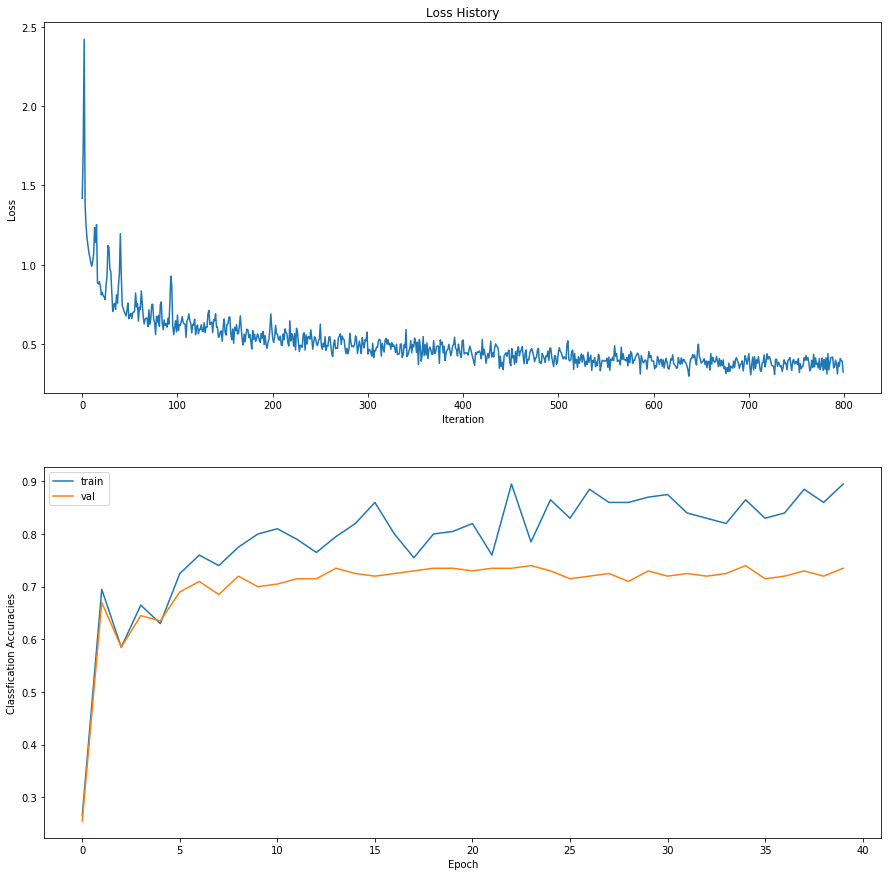

In [4]:
# plot loss history and train/ validation accuracies history
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.subplot(2,1,1) 
plt.plot(best_stats['loss_hist'])
plt.title('Loss History')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.plot(best_stats['train_acc_hist'], label='train')
plt.plot(best_stats['val_acc_hist'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Classfication Accuracies')
plt.legend()
plt.show()

In [5]:
#Seeing accuracy on the test set
print("Accuracy on Test set", (best_net.predict(X_test) == y_test).mean())  

Accuracy on Test set 0.77
